###  Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

# This makes it perfect for Agentic RAG:
    Think → Retrieve → Observe → Reflect → Final Answer

In [10]:
import os
from langchain.agents import create_agent
from langchain_core.tools import StructuredTool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [11]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: a0e6217f-27b4-4361-b3b2-be80b45391e9)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


In [12]:
retriever.invoke("what are autonomous agents")

[Document(id='1e0a513e-21a0-4788-a884-ddce257668cf', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [13]:
def retriever_tool_func(query: str) -> str:
    print(" Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [14]:
retriever_tool_func("what are autonomous agents")

 Using RAGRetriever tool


"Citation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources 

In [18]:
from langchain_core.tools import StructuredTool

retriever_tool = StructuredTool.from_function(
    func=retriever_tool_func,
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
)

print(retriever_tool.name)


RAGRetriever


In [19]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/Users/maruthienugula/RAG_learnings/.venv/lib/python3.12/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [21]:
import os
from langchain.chat_models import init_chat_model

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=init_chat_model("groq:openai/gpt-oss-120b")

## This is the internal graph

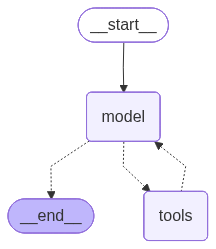

In [23]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------



tools = [retriever_tool, wiki_tool]

## create the native Langgraph react agent
react_node=create_agent(llm,tools)
react_node

In [24]:
result = react_node.invoke(
    {"messages": [("user", "search wikipedia for transformers")]}
)


In [25]:
result

{'messages': [HumanMessage(content='search wikipedia for transformers', additional_kwargs={}, response_metadata={}, id='f8e783c1-a278-4724-8655-5a0690201051'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User wants to "search wikipedia for transformers". Likely they want info about Transformers (maybe the franchise, or the machine learning model). The phrase ambiguous. Probably they want a summary. Let\'s search Wikipedia for "Transformers".', 'tool_calls': [{'id': 'fc_046ccce3-e631-4f1f-8888-d4719e974ab6', 'function': {'arguments': '{"query":"Transformers"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 186, 'total_tokens': 259, 'completion_time': 0.161834591, 'completion_tokens_details': {'reasoning_tokens': 46}, 'prompt_time': 0.008320643, 'prompt_tokens_details': None, 'queue_time': 0.045441015, 'total_time': 0.170155234}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_

In [26]:
# 3 langgraph agent state
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

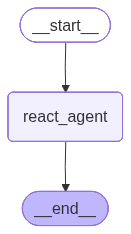

In [27]:
# 4 building a langgraph main graph
builder = StateGraph(AgentState)

builder.add_node("react_agent",react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent",END)

graph = builder.compile()
graph

In [28]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n Final Answer:\n", result["messages"][-1].content)


 Final Answer:
 **Agent Loop – the core “sense‑think‑act” cycle**

In the field of artificial‑intelligence and software‑agent design, an **agent loop** (sometimes called the *perception‑action loop* or *sense‑plan‑act loop*) is the repeated sequence of steps that an autonomous system follows in order to operate in its environment:

1. **Perceive / Sense** – The agent gathers data from the world through sensors, APIs, user input, or any other observation mechanism.  
2. **Interpret / Think** – It processes the observations, updates its internal state or belief model, and decides what to do next. This may involve:
   * reasoning, planning, or prediction,
   * evaluating an objective / utility function,
   * learning from past experience.
3. **Act / Execute** – The agent issues commands, performs an action, or sends a response that changes the environment (or its own internal state).  
4. **Loop back** – The consequences of the action become new observations, and the cycle repeats.

The 

### Tool creation for RAG agents with langgraph 
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

####  Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

In [29]:
import os
from typing import Annotated, Sequence, TypedDict

from langchain_community.vectorstores import FAISS
from langchain.agents import create_agent
from langchain_core.tools import StructuredTool
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import TextLoader


In [31]:
llm # just checking here

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x138630890>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x13874ffe0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [32]:
### Generic function to create a retireval tool
def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, embeddings)
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f" Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return StructuredTool.from_function(func=tool_func,name=name,description=desc)


In [34]:
# Wikipedia Tool
wiki_tool = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper()
)


# ArXiv Tool
def arxiv_search(query: str) -> str:
    print(" Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."

arxiv_tool = StructuredTool.from_function(
    func=arxiv_search,
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics."
)

In [43]:
internal_tool_1=make_retriever_tool_from_text(
    "sample-docs.txt",
    "sampledocs",
    "Agent loop and agent architecture"
)
internal_tool_1

StructuredTool(name='sampledocs', description='Agent loop and agent architecture', args_schema=<class 'langchain_core.utils.pydantic.sampledocs'>, func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x13911b060>)

In [44]:
internal_tool_2 = make_retriever_tool_from_text(
    "research-notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)
internal_tool_2

StructuredTool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', args_schema=<class 'langchain_core.utils.pydantic.InternalResearchNotes'>, func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x13ac9bce0>)

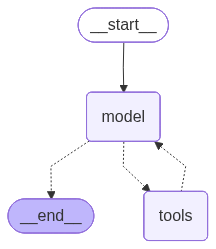

In [45]:
tools=[wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]

react_node=create_agent(llm,tools)
react_node

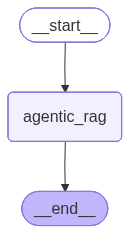

In [46]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph

In [48]:
query = "What do our research notes say about transformer variants,how does agent loop help atonomous agents  and what does ArXiv suggest recently?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

print("\n Final Answer:\n", result["messages"][-1].content)

 Using tool: InternalResearchNotes
 Using tool: InternalResearchNotes
 Searching ArXiv...
 Searching ArXiv...
 Using tool: InternalResearchNotes
 Searching ArXiv...
 Searching ArXiv...

 Final Answer:
 **1.  What our internal research notes say about *Transformer variants***  

| Variant | What we tried / measured | Key take‑aways (from the July‑2024 log) |
|---------|--------------------------|----------------------------------------|
| **EfficientFormer** | Tiny‑ImageNet (92.4 % top‑1) – batch‑size 16, 290 MB RAM on a Raspberry Pi 4. Tested in INT8‑quantised mode. | • Very friendly to edge devices – no noticeable accuracy loss after quantisation.<br>• Memory‑footprint is ≈ 30 % of a vanilla ViT of comparable depth. |
| **Longformer** | Ran on internal customer‑support logs (max 8 k tokens). Latency ≈ 1.2 s per query in a streaming set‑up. | • Linear‑time sliding‑window + a few global tokens works for very long documents.<br>• Still a bottleneck when low‑latency (≤ 200 ms) responses a